In [1]:
import __main__
print(__main__.__package__)

None


In [2]:
import sys
import os

sys.path.append(os.path.abspath("..")) 

In [3]:
# # run this if you haven't had the data

# import kagglehub

# path = kagglehub.dataset_download("financekim/curated-cxr-report-generation-dataset")

# print("Path to dataset files:", path)

In [4]:
df_dir = "../data/13/Cleanses csv tfrecords/"
df_train_name = "df_train.csv"
df_val_name = "df_val.csv"

In [5]:
import pandas as pd

mimic_df_train = pd.read_csv(df_dir + df_train_name)
mimic_df_test = pd.read_csv(df_dir + df_val_name)

In [6]:
mimic_df_train.head()

,id,text,path
0,s50260386,A tip of a left Port-A-Cath lies in the low su...,../input/curated-cxr-report-generation-dataset...
1,s58019009,"AP chest compared to ___, 9:04 a.m.: In place ...",../input/curated-cxr-report-generation-dataset...
2,s54123565,"AP chest compared to ___, read in conjunction ...",../input/curated-cxr-report-generation-dataset...
3,s51811896,A tracheostomy cannula is located within the u...,../input/curated-cxr-report-generation-dataset...
4,s59641633,Bilateral previous mentioned reticular opaciti...,../input/curated-cxr-report-generation-dataset...


In [7]:
mimic_df_test.head()

,id,text,path
0,s55512076,Comparison is made to prior study performed a ...,../input/curated-cxr-report-generation-dataset...
1,s55786650,"As compared to the previous radiograph, there ...",../input/curated-cxr-report-generation-dataset...
2,s56188631,AP chest compared to ___ through ___. Elevatio...,../input/curated-cxr-report-generation-dataset...
3,s53690114,Compared to prior study there is no significan...,../input/curated-cxr-report-generation-dataset...
4,s52070116,In comparison to prior radiograph of 1 day ear...,../input/curated-cxr-report-generation-dataset...


In [8]:
print(f"Shape train data: {mimic_df_train.shape}")
print(f"Shape test data: {mimic_df_test.shape}")

Shape train data: (93347, 3)
Shape test data: (1885, 3)


In [9]:
train_img_dir = '../data/13/mimic_dset/re_512_3ch/Train'
test_img_dir = '../data/13/mimic_dset/re_512_3ch/Test'

In [10]:
# Prepare Dataset
mimic_df_train['path'] = mimic_df_train.apply(lambda x: f"{train_img_dir}/{x['id']}.jpg", axis=1)
mimic_df_test['path'] = mimic_df_test.apply(lambda x: f"{test_img_dir}/{x['id']}.jpg", axis=1)

In [11]:
def sampling(df, sample_size, seed=42):
  valid = pd.DataFrame()
  remaining_df = df.copy()

  while len(valid) < sample_size:
    n_needed = sample_size - len(valid)
    sample = remaining_df.sample(n=n_needed, random_state=seed)
    # Check if the file exists or not
    sample['exists'] = sample['path'].apply(os.path.exists)
    valid_samples = sample[sample['exists']]
    valid = pd.concat([valid, valid_samples], ignore_index=True)
    remaining_df = remaining_df.drop(index=sample.index)

    if remaining_df.empty and len(valid) < sample_size:
      break # no more data
  return valid.drop(columns=['exists']).reset_index(drop=True)

In [12]:
# Sampling Sata
train_df = sampling(mimic_df_train, 3000)
test_df = sampling(mimic_df_test, 300)

In [13]:
print(f"Train Data Shape: {train_df.shape}")
print(f"Test Data Shape: {test_df.shape}")

Train Data Shape: (3000, 3)
Test Data Shape: (300, 3)


Index Data: 0
Captions: Single upright AP image of the chest. Lungs well expanded and clear. There is no pleural effusion or pneumothorax. The cardiomediastinal silhouette is unremarkable. No free air is seen in the upper abdomen.


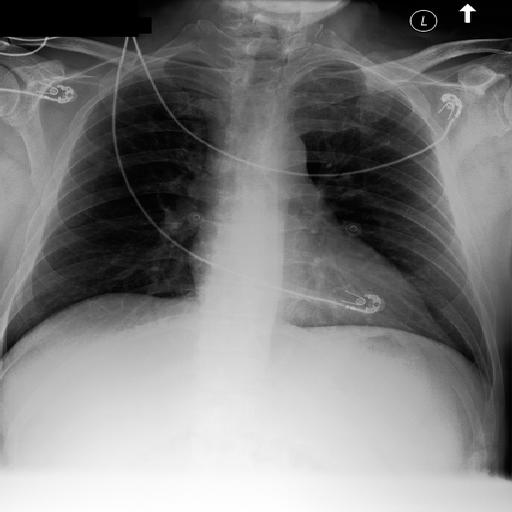

In [14]:
# Data Example
from PIL import Image

print("=" * 50)
print("Index Data: 0")
print(f"Captions: {train_df['text'][0]}")
print("=" * 50)
Image.open(train_df['path'][0])

In [15]:
VOCAB_SIZE_TARGET = 5000
PAD_TOKEN = "<PAD>"
SOS_TOKEN = "<SOS>"
EOS_TOKEN = "<EOS>"
UNK_TOKEN = "<UNK>"

In [16]:
MODEL_IMG_HEIGHT = 128 # patch size will be 16 so that (128 / 16) ^ 2 = 64 sequence length for the input
MODEL_IMG_WIDTH = 128
MODEL_IN_CHANNEL = 1 # just grayscale so that lighter

In [ ]:
# Use the utils code part to generate

vocab_path = '../data/mimic-dset-3300-data/vocab.json'
id2token_path = '../data/mimic-dset-3300-data/id2token.json'

In [18]:
import json

with open(vocab_path, 'r') as f:
    vocab = json.load(f)

with open(id2token_path, 'r') as f:
    id2token = json.load(f)

In [19]:
# Just use the torchvision for image processing
import torchvision.transforms as transforms

image_transform = transforms.Compose([
    transforms.Resize((MODEL_IMG_HEIGHT, MODEL_IMG_WIDTH)),
    transforms.Grayscale(num_output_channels = MODEL_IN_CHANNEL),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # for 1 channel grayscale image maps [0, 1] -> [-1, 1]
])

In [20]:
device = 'cuda:1'

In [21]:
from transformer.vit_transformer import VisionTransformer

model = VisionTransformer(
    width=MODEL_IMG_WIDTH,
    height=MODEL_IMG_HEIGHT,
    patch_size=16, 
    in_channel=MODEL_IN_CHANNEL,
    num_enc_layers=2,
    num_dec_layers=2,
    num_heads=4,
    hidden_dim=256,
    dropout_p=0.1,
    embed_dim=128,
    tgt_pad_idx=vocab[PAD_TOKEN],
    tgt_vocab_size=len(vocab),
    max_seq_length=64
)

In [22]:
img_path = train_df['path'][0]

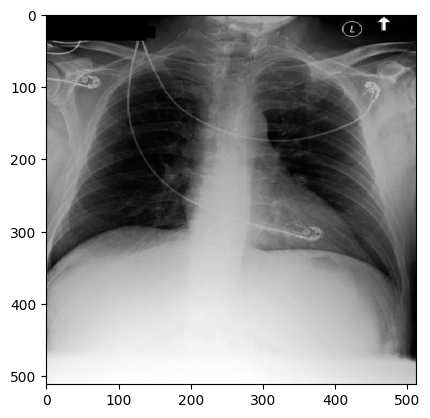

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -0.9843, -0.9843],
          ...,
          [ 0.8902,  0.8980,  0.8980,  ...,  0.5843,  0.5765,  0.5608],
          [ 0.9059,  0.9059,  0.9137,  ...,  0.6078,  0.6000,  0.5922],
          [ 0.9216,  0.9216,  0.9294,  ...,  0.6314,  0.6235,  0.6157]]]])


In [ ]:
import matplotlib.pyplot as plt
try:
    pil_image = Image.open(img_path)
    plt.imshow(pil_image)
    plt.show()

    print(f"PIL Image: {pil_image}")
    print(f"PIL Image Shape: {pil_image.shape}")
    image_tensor = image_transform(pil_image)
    image_batch = image_tensor.unsqueeze(0)
    print(f"Image Batch: {image_batch}")
    print(f"Image Batch Shape: {image_batch.shape}")
except:
    pass

In [43]:
import torch

tgt_sequence_list = [vocab[SOS_TOKEN]] + [vocab[PAD_TOKEN]] * 63
tgt = torch.tensor([tgt_sequence_list], dtype=torch.long)

In [23]:
model.to(device)

VisionTransformer(
  (encoder): ViTEncoder(
    (patch_embedding): PatchEmbedding(
      (projection): Sequential(
        (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
        (1): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (multi_attn): MultiHeadAttention(
          (q_proj): Linear(in_features=128, out_features=128, bias=True)
          (k_proj): Linear(in_features=128, out_features=128, bias=True)
          (v_proj): Linear(in_features=128, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (softmax_similarity): Softmax(dim=-1)
        )
        (ffn): PositionWiseFeedForward(
          (linear1): Linear(in_features=128, out_features=256, bias=True)
          (activation1): GELU(approximate='none')
          

In [46]:
image_batch = image_batch.to(device)
tgt = tgt.to(device)

In [47]:
model.eval()

with torch.no_grad():
    output_logits = model(image_batch, tgt)
    print(f"Output logits: {output_logits}")


Linear Projection
Query: tensor([[[-0.7770, -0.6220, -0.2551,  ..., -0.1943, -0.1102, -0.6044],
         [ 0.2196, -0.8002, -0.4936,  ..., -0.6890,  0.6855, -1.0086],
         [ 0.3672, -1.1458, -0.8112,  ..., -0.2949, -0.6260, -0.5895],
         ...,
         [ 0.1604,  0.0447, -0.1522,  ..., -0.2808,  0.1804,  0.3862],
         [-0.2366, -0.3103,  0.6695,  ...,  0.2805, -0.9911, -0.7037],
         [-0.1771,  0.0106, -0.2938,  ..., -0.0154,  0.2781,  0.4380]]],
       device='cuda:1')
Query Shape: torch.Size([1, 65, 128])
Key: tensor([[[ 1.0196,  0.0445, -0.2326,  ...,  0.4807,  0.7614,  0.2720],
         [-0.2981, -0.7529,  0.2056,  ..., -0.2206, -0.4377,  0.1942],
         [-0.8070,  0.2369,  0.2615,  ..., -0.1426,  0.7592, -0.3906],
         ...,
         [-0.1619,  0.0526,  0.1199,  ...,  0.4847,  0.7801,  0.3175],
         [ 0.2537,  0.6567,  0.0537,  ..., -0.1263,  0.1705, -0.1008],
         [-0.5782,  0.0907,  1.2421,  ..., -0.0457,  0.1156,  0.6393]]],
       device='cuda:1')


In [49]:
output_logits.shape

torch.Size([1, 64, 4586])

In [50]:
probabilities = torch.softmax(output_logits, dim=-1)

In [53]:
predicted_id = torch.argmax(probabilities, dim=-1)

In [66]:
predicted_token = [id2token.get(str(idx.item()), "UNK") for idx in predicted_id[0]]

In [67]:
print(f"Predicted Token: {predicted_token}")

Predicted Token: ['tree,', 'looping', 'looping', 'looping', '46', 'looping', 'looping', 'looping', 'looping', 'detect', 'skeletal', 'skeletal', 'looping', 'looping', 'looping', 'looping', 'detect', 'detect', 'looping', 'looping', 'looping', 'looping', 'looping', 'looping', 'looping', 'looping', 'looping', 'looping', 'looping', 'looping', 'remote', 'remote', 'remote', 'looping', 'looping', 'looping', 'remote', 'remote', 'remote', 'remote', 'calcium,', 'detect', 'detect', 'detect', 'looping', 'looping', 'looping', 'looping', 'looping', 'variation', 'looping', 'looping', 'looping', 'looping', 'looping', 'looping', 'looping', 'looping', 'looping', 'looping', 'fat', 'looping', 'looping', 'looping']


In [24]:
from transformer.dataset.vit_dataset import ViTDataset

train_datasets = ViTDataset(
    dataframe=train_df,
    vocab=vocab, 
    max_seq_length=64,
    image_transform=image_transform,
    sos_token_id=vocab[SOS_TOKEN],
    pad_token_id=vocab[PAD_TOKEN],
    eos_token_id=vocab[EOS_TOKEN],
    unk_token_id=vocab[UNK_TOKEN],
)

In [30]:
test_datasets = ViTDataset(
    dataframe=test_df,
    vocab=vocab, 
    max_seq_length=64,
    image_transform=image_transform,
    sos_token_id=vocab[SOS_TOKEN],
    pad_token_id=vocab[PAD_TOKEN],
    eos_token_id=vocab[EOS_TOKEN],
    unk_token_id=vocab[UNK_TOKEN],
)

In [25]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_datasets, batch_size=64, shuffle=True, num_workers=2)

In [31]:
test_dataloader = DataLoader(test_datasets, batch_size=64, shuffle=False, num_workers=2)

In [37]:
for i, (images, captions_input, captions_target_for_loss) in enumerate(train_dataloader):
    print(f"Index: {i}")
    print(f"Image: {images}")
    break

Index: 0
Image: tensor([[[[-1.0000, -1.0000, -0.9843,  ..., -0.9843, -0.9765, -0.9765],
          [-1.0000, -1.0000, -0.9843,  ..., -0.9686, -0.9765, -0.9765],
          [-1.0000, -1.0000, -0.9843,  ..., -0.9686, -0.9765, -0.9765],
          ...,
          [-1.0000, -1.0000, -0.7647,  ..., -0.3098, -0.4824, -0.7255],
          [-1.0000, -1.0000, -0.9686,  ..., -0.0196, -0.1922, -0.4588],
          [-1.0000, -1.0000, -1.0000,  ...,  0.4196,  0.2784,  0.0431]]],


        [[[-0.9922, -0.9922, -0.9922,  ..., -0.9373, -0.9373, -0.9373],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9373, -0.9373, -0.9373],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9373, -0.9373, -0.9373],
          ...,
          [-0.9294, -0.9608, -0.9373,  ..., -0.9765, -0.9608, -0.9686],
          [-0.9373, -0.9529, -0.9451,  ..., -0.9686, -0.9608, -0.9686],
          [-0.9373, -0.9529, -0.9608,  ..., -0.9765, -0.9608, -0.9686]]],


        [[[-0.9922, -0.9922, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
          

In [26]:
# Loss Function
import torch.nn as nn

criterion = nn.CrossEntropyLoss(ignore_index=vocab[PAD_TOKEN])

In [27]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [28]:
NUM_EPOCHS = 5

In [35]:
from tqdm import tqdm

model.train()
for epoch in range (NUM_EPOCHS):
    loss = 0.0

    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for i, (images, captions_input, captions_target_for_loss) in enumerate(pbar):
        images = images.to(device)
        captions_input = captions_input.to(device)
        captions_target_for_loss = captions_target_for_loss.to(device)

        optimizer.zero_grad()

        output_logits = model(images, captions_input)

        loss = criterion(
            output_logits.view(-1, model.tgt_vocab_size),
            captions_target_for_loss.view(-1)
        )

        loss.backward()
        optimizer.step()

        loss += loss.item()
        pbar.set_postfix(loss=loss.item())
        
    print(f"Epoch {epoch+1}, Average Loss: {loss / len(train_dataloader):.4f}")

Epoch 1/5: 100%|██████████| 47/47 [00:05<00:00,  8.71it/s, loss=10.1]


Epoch 1, Average Loss: 0.2141


Epoch 2/5: 100%|██████████| 47/47 [00:05<00:00,  8.76it/s, loss=9.66]


Epoch 2, Average Loss: 0.2055


Epoch 3/5: 100%|██████████| 47/47 [00:05<00:00,  8.53it/s, loss=9.55]


Epoch 3, Average Loss: 0.2033


Epoch 4/5: 100%|██████████| 47/47 [00:05<00:00,  8.62it/s, loss=9.3] 


Epoch 4, Average Loss: 0.1978


Epoch 5/5: 100%|██████████| 47/47 [00:05<00:00,  8.74it/s, loss=9.47]

Epoch 5, Average Loss: 0.2015


In [32]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smoothie = SmoothingFunction().method4

In [36]:
import torch

model.eval()
bleu_scores = []

pad_token_id = vocab[PAD_TOKEN]
eos_token_id = vocab[EOS_TOKEN]

with torch.no_grad():
    for images, captions_input, captions_target in test_dataloader:
        images = images.to(device)
        captions_input = captions_input.to(device)

        output_logits = model(images, captions_input)
        predicted_ids = output_logits.argmax(-1)

        for pred, ref in zip(predicted_ids, captions_target):
            pred_tokens = [id2token.get(str(idx.item()), '<unk>') for idx in pred if idx.item() not in [pad_token_id, eos_token_id]]
            ref_tokens = [id2token.get(str(idx.item()), '<unk>') for idx in ref if idx.item() not in [pad_token_id, eos_token_id]]

            bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
            bleu_scores.append(bleu)

print(f"Average BLEU score: {sum(bleu_scores)/len(bleu_scores):.4f}")

Average BLEU score: 0.0529
